In [ ]:
from enum import IntEnum
from time import sleep

import numpy as np

import GCode
import GRBL
from utils import picture


# Drawing Tests

## Object
- Play around with drawing things.

# Code:

In [95]:
cnc = GRBL.GRBL(port="/dev/cnc_3018")print("Laser Mode: {}".format(cnc.laser_mode))class Tool(IntEnum):    SPINDLE = 0    LASER = 1class LaserPower(IntEnum):    CONSTANT = 0    DYNAMIC = 1LaserPower.CONSTANTdef init(power_mode=LaserPower(0), feed=200, pwm=1):    program = GCode.GCode()    program.G21()  # Metric Units    program.G91()  # Absolute positioning.    program.G1(F=feed)  #    if power_mode == LaserPower.CONSTANT:        program.M3(S=pwm)  # Laser settings    else:        program.M4(S=pwm)  # Laser settings    return programdef end():    program = GCode.GCode()    program.M5()  # Laser settings.    return programdef square(size=0.25):    program = GCode.GCode()    program.G1(X=size)    program.G1(Y=-size)    program.G1(X=-size)    program.G1(Y=size)    return program

Laser Mode: 1.0


## Test Setup

Power Supply:
- CicuitSpecialists CSI3010SW @ 12V
- PostIt Note Grid notes. .25" grid.

Position the paper & other things.

In [81]:
def laser_on(pwm):
    if int(pwm) != np.uint8(pwm):
        raise (Exception("UINT8! {}".format(pwm)))
    # Set minimal power setting to focus and position laser
    cnc.cmd("M3 S{:03d}".format(np.uint8(pwm)))
    cnc.cmd("G1 F10")  # Laser On


def laser_off():
    cnc.cmd("M5")  # Laser off


In [34]:
cnc.cmd("$X")


['ok', 'ok']

In [35]:
cnc.cmd("G1 F10")


['ok', 'ok']

In [22]:
laser_on(1)  # Position the axis by hand


In [21]:
laser_off()


In [54]:
tests_x = 10
tests_y = 7


In [40]:
cnc.run(init(laser=0.1) + square(0.25))


0.8319504261016846

In [23]:
def jogx(x=10):
    program = GCode.GCode()
    program.G0(X=x)
    cnc.run(program)


def jogy(y=10):
    program = GCode.GCode()
    program.G0(Y=y)
    cnc.run(program)


def jogz(z=10):
    program = GCode.GCode()
    program.G0(Z=z)
    cnc.run(program)


# Test Setup

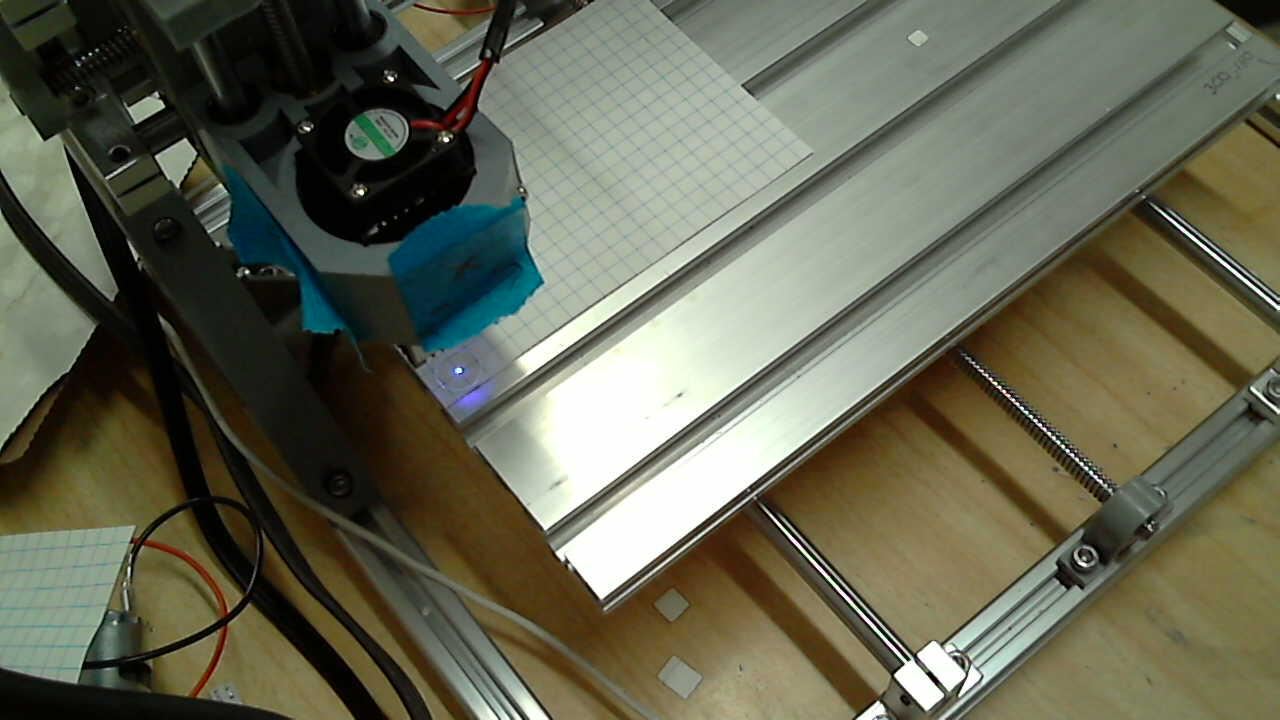

In [49]:
picture()


In [100]:
def test_program(power_mode=0, feed=100, pwm=1):
    program = GCode.GCode()
    program += init(power_mode=power_mode, pwm=pwm, feed=feed)
    negX = 0
    negZ = 0
    for dZ in [5, 5, 5, 5]:
        dX = 10
        program.G1(X=dX, Z=dZ, F=feed)

        negX -= dX
        negZ -= dZ
    program.G0(X=negX, Z=negZ)

    program += end()
    return program


In [101]:
test_program()


<GCode>[cmds=10]

In [102]:
test_program(pwm=50, feed=200)


<GCode>[cmds=10]

In [106]:
# This test is going to immediately run out of Y axis. To test Ctrl-C and interrupting tests.
test_run = GCode.GCode()
for pwm in [25, 50, 255]:
    for feed in [50, 100, 250, 500, 750, 1000]:
        for power_mode in [LaserPower.CONSTANT, LaserPower.DYNAMIC]:
            test_run += test_program(pwm=50, feed=200)
            test_run.G0(Y=10)


In [107]:
test_run


<GCode>[cmds=396]

In [108]:
test_run.save("DrawingTests-Copy1.gcode")


In [109]:
test_run = GCode.GCode()


In [110]:
test_run.load("DrawingTests-Copy1.gcode")


In [111]:
test_run.buffer[0:5]


['G21', 'G91', 'G1 F200', 'M3 S50', 'G1 F200 X10 Z5']

In [113]:
cnc.reset()


In [114]:
cnc.status


'<Idle|MPos:0.000,0.000,-5.000|Bf:15,127|FS:0,0|WCO:0.000,0.000,0.000>'

In [121]:
while 1:
    try:
        cnc.run(test_run)
        while 1:
            print(cnc.status)
            sleep(5)
    except KeyboardInterrupt as error:
        print("Feed Hold")
        cnc.cmd("!")
        print("^C")
        break
    except:
        raise


.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
Feed Hold
^C


In [124]:
cnc.cmd("?")
# .status does not return 'ok'/'ok' when this requested on hold.


['<Hold:0|MPos:21.548,70.000,5.774|Bf:12,0|FS:0,0>']

GRBL Source that controls this string: https://github.com/gnea/grbl/blob/master/grbl/report.c

Bf = Plan block buffer available.
FS = real-time feed rate & spindle speed.

# New Test Setup!

This notebook's structure makes it much easier to run tests and debug before exceuting the tests.

- Makes it easier & safer to interrupt test (^C / interrupt)
- Saves the GCode for version control.
- 